In [18]:
# Import my packages.
import flymovie as fm
import tensorflow as tf
import os
import copy
import scipy
import skimage as ski
import scipy.ndimage as ndi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import dask
from time import sleep
import seaborn as sns
import itertools

from math import sqrt
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

# Activate package autoload.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
def prepare_hist_param_data(data, num_hist_bins=400, param_pos=0, data_pos=1):
    """Process data output from blob simulator (list of tuples, 
    0 is params, 1 is 2d histogram) for feeding to ML function. 
    
    For histograms: 
        - Bin (if desired)
        - Normalize each 1d histogram by dividing by sum (-> probabilities)
        - Flatten
        - Take log (after adding a bit to avoid 0)

    For parameters:
        - Combine into single 2d numpy array (rows are entries)
        - Normalize each column (mean 0 sd 1)
    
         """
    def check2d(a):
        """Add dummy first dimension if array is 1d."""
        if len(a.shape) < 2:
            a = np.expand_dims(a, axis=0)
        return a

    def rebin(a, shape):
        sh = shape[0],a.shape[0]//shape[0],shape[1],a.shape[1]//shape[1]
        return a.reshape(sh).mean(-1).mean(1)

    def norm_columns(x):
        """Normalize columns to mean=0 SD=1."""
        x1 = x.copy()
        for i in range(0, x.shape[1]):
            sd = np.std(x[:,i])
            if sd > 0:
                x1[:,i] = (x[:,i] - np.mean(x[:,i])) / sd
            else:
                x1[:,i] = np.zeros(len(x1[:,i]))
        return x1

    num_sigmas = check2d(data[0][data_pos]).shape[0]
    num_params = len(data[0][param_pos])
    num_entries = len(data)
    histograms_processed = np.zeros((num_entries, num_sigmas * num_hist_bins))
    params = np.zeros((num_entries, num_params))

    for i in range(num_entries):
        params[i] = data[i][param_pos]
        hist2d = data[i][data_pos].copy()
        hist2d = check2d(hist2d)
        # Bin histograms.
        hist2d = rebin(hist2d, [hist2d.shape[0], num_hist_bins])
        # Normalize by dividing by row sum.
        hist2d = np.apply_along_axis(lambda x: x / np.sum(x), axis=1, arr=hist2d)
        # Flatten.
        hist_flattened = hist2d.flatten()
        # Add small number to account for 0s, take log, assign.
        zero_pad = np.min(hist_flattened[hist_flattened > 0]) / 100
        hist_flatlog = np.log(hist_flattened + zero_pad)
        histograms_processed[i] = hist_flatlog

    params = norm_columns(params)    
    return histograms_processed, params

def create_training_test_data(data, num_hist_bins=100, n_leaveout=100, param_pos=0, data_pos=1, permute=True):
    histograms, params = prepare_hist_param_data(data, num_hist_bins, param_pos, data_pos)
    if permute:
        p = np.random.permutation(histograms.shape[0])
    else:
        p = np.arange(0, histograms.shape[0])

    if n_leaveout > 0:       
        x_train = histograms[p[:-n_leaveout]]
        y_train = params[p[:-n_leaveout]]
        x_test = histograms[p[-n_leaveout:]]
        y_test = params[p[-n_leaveout:]]
        
        return x_train, y_train, x_test, y_test
    else:
        x_train, y_train = histograms, params
        return x_train, y_train

def difference_hist_params(histograms, params, dist_func=scipy.spatial.distance.euclidean):
    num_entries = histograms.shape[0]
    hist_diffs = np.zeros((num_entries * num_entries, histograms.shape[1]))
    param_diffs = np.zeros(num_entries * num_entries)
    for i in range(num_entries):
        start = i * num_entries
        hist_diffs[start : (start + num_entries)] = histograms - histograms[i]
        # Get parameter distances.
        param_diffs[start : (start + num_entries)] = np.apply_along_axis(lambda x: dist_func(x, params[i]), axis=1, arr=params)

    return hist_diffs, param_diffs

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def merge_data(x_train1, x_train2, y_train1, y_train2):
    def argsortcols(a, cols):
        cols_ext = []
        for col in cols:
            cols_ext.append(a[:,col])
        return np.lexsort(cols_ext)

    order1 = argsortcols(y_train1, np.arange(0, y_train1.shape[1]))
    order2 = argsortcols(y_train2, np.arange(0, y_train2.shape[1]))
    y_train1_new = y_train1[order1]
    y_train2_new = y_train2[order2]
    if np.max(abs(y_train1_new - y_train2_new)) > 1e-5:
        raise ValueError('Sorted y_train sets are not identical')
    x_train_new = np.hstack((x_train1[order1], x_train2[order2]))
    return x_train_new, y_train1_new

def make_data_similarity(x_in, y_in, num_sample, num_diff):
    total = num_sample * num_diff
    x = np.zeros((total, x_in.shape[1]))
    y = np.zeros((total, 1))
    indexes = np.arange(0, x_in.shape[0])
    sampled_indexes1 = np.random.choice(indexes, size=num_sample, replace=False)
    for i in range(len(sampled_indexes1)):
        start = i * num_diff
        end = start + num_diff
        index1 = sampled_indexes1[i]
        indexes_sansself = np.concatenate((indexes[:index1], indexes[(index1 + 1):]))
        sampled_indexes2 = np.random.choice(indexes_sansself, size=num_diff, replace=False)
        x_sub = x_in[sampled_indexes2]
        y_sub = y_in[sampled_indexes2]
        x_diffs = x_sub - x_in[index1]
        y_diffs = np.sum((y_sub - y_in[index1]) ** 2, axis=1) # sum of squared differences
        x[start:end] = x_diffs
        y[start:end] = np.expand_dims(y_diffs, axis=1)

    return x, y

In [ ]:
bg_mean_range=[10_000]
bg_var_range=np.arange(2700, 3300, 500)  
blob_intensity_mean_range=np.arange(15_000, 25_000, 250)
blob_intensity_var_range=np.arange(500, 10_000, 1000)
blob_radius_mean_range=[0.3, 0.5, 0.7]
blob_radius_var_range=[0.25, 0.5]
blob_number_range = [0, 10, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300]

len(bg_mean_range) * len(bg_var_range) * len(blob_intensity_mean_range) * len(blob_intensity_var_range) * len(blob_radius_mean_range) * len(blob_radius_var_range) * len(blob_number_range)

In [99]:
data = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist1_to_4_by1.pkl')
x_train1, y_train1, x_test1, y_test1 = create_training_test_data(data, 400, param_pos=1, data_pos=0)

In [127]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-6
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(400, 7)
history = model.fit(x_train1, y_train1, validation_split=0.1,epochs=20, verbose=True)

Epoch 1/20
1618/1618 [==============================] - 5s 3ms/step - loss: 1.5643 - val_loss: 0.5790
Epoch 2/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.5456 - val_loss: 0.6682
Epoch 3/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.4870 - val_loss: 0.5017
Epoch 4/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.4657 - val_loss: 0.4933
Epoch 5/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.4336 - val_loss: 0.4646
Epoch 6/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.4067 - val_loss: 0.4137
Epoch 7/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.3897 - val_loss: 0.4062
Epoch 8/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.3749 - val_loss: 0.3307
Epoch 9/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.3685 - val_loss: 0.3904
Epoch 10/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.354

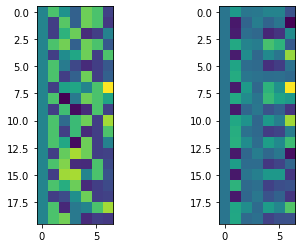

In [75]:
fig, ax = plt.subplots(1,2)
axes = np.ravel(ax)
axes[0].imshow(y_test[:20])
axes[1].imshow(model.predict(x_test)[:20])

In [58]:
data = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p5.pkl')
x_train2, y_train2, x_test2, y_test2 = create_training_test_data(data, 800, param_pos=1, data_pos=0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p5.pkl'

In [131]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-6
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(800, 7)
history = model.fit(x_train2, y_train2, validation_split=0.1,epochs=20, verbose=True)

Epoch 1/20
1618/1618 [==============================] - 6s 3ms/step - loss: 1.7507 - val_loss: 0.5658
Epoch 2/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.4243 - val_loss: 0.5614
Epoch 3/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.4017 - val_loss: 0.3551
Epoch 4/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.3838 - val_loss: 0.3394
Epoch 5/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.3469 - val_loss: 0.3901
Epoch 6/20
1618/1618 [==============================] - 6s 4ms/step - loss: 0.3074 - val_loss: 0.3141
Epoch 7/20
1618/1618 [==============================] - 6s 3ms/step - loss: 0.2814 - val_loss: 0.2767
Epoch 8/20
1618/1618 [==============================] - 6s 3ms/step - loss: 0.2608 - val_loss: 0.2603
Epoch 9/20
1618/1618 [==============================] - 6s 4ms/step - loss: 0.2503 - val_loss: 0.3106
Epoch 10/20
1618/1618 [==============================] - 5s 3ms/step - loss: 0.237

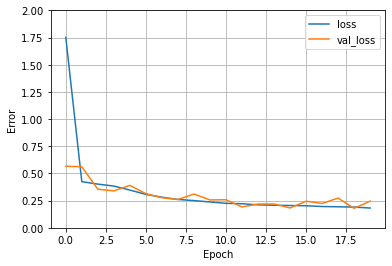

In [132]:
plot_loss(history)

In [20]:
data = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p25.pkl')
x_train, y_train, x_test, y_test = create_training_test_data(data, 1500, param_pos=1, data_pos=0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p25.pkl'

In [119]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(1500, 7)
history = model.fit(x_train, y_train, validation_split=0.1,epochs=20, verbose=True)

Epoch 1/20
1618/1618 [==============================] - 7s 4ms/step - loss: 1.8300 - val_loss: 0.8855
Epoch 2/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.5167 - val_loss: 0.5267
Epoch 3/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.4586 - val_loss: 0.4160
Epoch 4/20
1618/1618 [==============================] - 6s 4ms/step - loss: 0.4299 - val_loss: 0.3552
Epoch 5/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.3893 - val_loss: 0.4535
Epoch 6/20
1618/1618 [==============================] - 6s 4ms/step - loss: 0.3503 - val_loss: 0.3441
Epoch 7/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.3313 - val_loss: 0.3486
Epoch 8/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.3025 - val_loss: 0.3569
Epoch 9/20
1618/1618 [==============================] - 8s 5ms/step - loss: 0.2872 - val_loss: 0.3171
Epoch 10/20
1618/1618 [==============================] - 8s 5ms/step - loss: 0.271

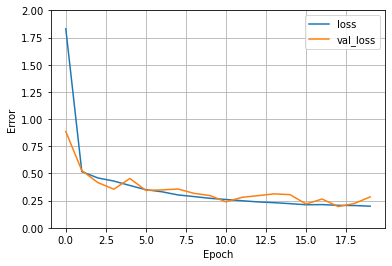

In [120]:
plot_loss(history)

In [125]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-6
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(1500, 7)
history = model.fit(x_train, y_train, validation_split=0.1,epochs=20, verbose=True)

Epoch 1/20
1618/1618 [==============================] - 9s 5ms/step - loss: 2.5489 - val_loss: 0.6240
Epoch 2/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.4878 - val_loss: 0.4579
Epoch 3/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.4530 - val_loss: 0.5143
Epoch 4/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.4150 - val_loss: 0.3569
Epoch 5/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.3681 - val_loss: 0.2891
Epoch 6/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.3306 - val_loss: 0.3102
Epoch 7/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.3148 - val_loss: 0.3229
Epoch 8/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.2921 - val_loss: 0.2939
Epoch 9/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.2754 - val_loss: 0.2260
Epoch 10/20
1618/1618 [==============================] - 7s 4ms/step - loss: 0.267

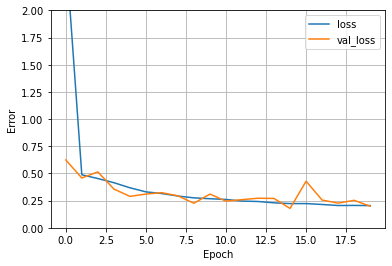

In [126]:
plot_loss(history)

## Testing with 2x sims

In [21]:
data1 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p5.pkl')
data2 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-2-sshist_0p5_to_4_by0p5.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p5.pkl'

In [153]:
histograms1, params1 = prepare_hist_param_data(data1, 800, param_pos=1, data_pos=0)
histograms2, params2 = prepare_hist_param_data(data2, 800, param_pos=1, data_pos=0)
p = np.random.permutation(histograms1.shape[0])

x_train2 = np.vstack([histograms1[p[:-n_leaveout]], histograms2[p[:-n_leaveout]]])
y_train2 = np.vstack([params1[p[:-n_leaveout]], params2[p[:-n_leaveout]]])
x_test2 = np.vstack([histograms1[p[-n_leaveout:]], histograms2[p[-n_leaveout:]]])
y_test2 = np.vstack([params1[p[-n_leaveout:]], params2[p[-n_leaveout:]]])

In [154]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-6
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(800, 7)
history = model.fit(x_train2, y_train2, validation_split=0.1,epochs=20, verbose=True)

Epoch 1/20
3235/3235 [==============================] - 14s 4ms/step - loss: 1.2338 - val_loss: 0.4560
Epoch 2/20
3235/3235 [==============================] - 13s 4ms/step - loss: 0.3982 - val_loss: 0.3365
Epoch 3/20
3235/3235 [==============================] - 12s 4ms/step - loss: 0.3381 - val_loss: 0.4373
Epoch 4/20
3235/3235 [==============================] - 12s 4ms/step - loss: 0.2915 - val_loss: 0.2794
Epoch 5/20
3235/3235 [==============================] - 12s 4ms/step - loss: 0.2677 - val_loss: 0.2114
Epoch 6/20
3235/3235 [==============================] - 12s 4ms/step - loss: 0.2466 - val_loss: 0.2340
Epoch 7/20
3235/3235 [==============================] - 12s 4ms/step - loss: 0.2354 - val_loss: 0.1883
Epoch 8/20
3235/3235 [==============================] - 13s 4ms/step - loss: 0.2162 - val_loss: 0.2133
Epoch 9/20
3235/3235 [==============================] - 13s 4ms/step - loss: 0.2085 - val_loss: 0.1561
Epoch 10/20
3235/3235 [==============================] - 13s 4ms/step - l

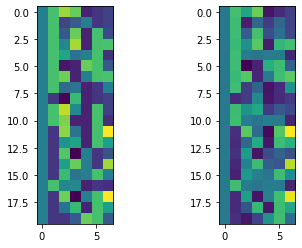

In [156]:
fig, ax = plt.subplots(1,2)
axes = np.ravel(ax)
axes[0].imshow(y_test2[:20])
axes[1].imshow(model.predict(x_test2)[:20])

Little check in...

Looks like a deeper architecture (4x500) definitely outperforms others. Dropout is awful (using 0.1) and just crushes the model. L2 regularization seems fine, might help a little, unclear. Also a lower learning rate seems to help. Doubling the simulations certainly helped, so that's a useful data point.

## Try new transformations

In [ ]:
im = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/simdump/10000_3500_35000_12000_1.5_0.75_100.pkl')

In [212]:
from flymovie import dog_filter
############################################################################
def make_DoG_histograms(stack, mask=None, smallsigmas=[0.5, 1], bigsigmas=
    [2,3,4], numbins=100, histrange=(0,65_000)):
    """Make a 2D scale-space histogram of an image stack using difference
    of Gaussian (DoG) filter for scale axis.

    Args:
        stack: ndarray
            Image stack
        mask: ndarray
            (optional) Mask for values to be included in histogram calculation
        smallsigmas: iterable of numeric
            Values to use for the smaller sigma value in DoG filter
        bigsigmas: iterable of numeric
            Values to use for the larger sigma value in DoG filter
        numbins: int
            Number of bins to use for histogram
        histrange: (int, int)
            Range of values to be included in histogram
    
    Returns:
        hist_data: ndarray
            Histogram data for each pair of sigma values. Dimensions
            are (# smallsigmas x # bigsigmas) x numbins
    """
    def get_pixel_vals(stack, mask):
        """Create flattened array of values in mask foreground of image 
        stack."""
        if mask is not None:
            return stack[np.where(mask)]
        else:
            return stack.flatten()

    hist_data = np.zeros(tuple([len(smallsigmas) * len(bigsigmas), numbins]))  
    n = 0 # Keep track of where to add new histogram.     
    for smallsigma in smallsigmas:
        for bigsigma in bigsigmas:
            dog = dog_filter(stack, bigsigma, smallsigma)
            vals = get_pixel_vals(dog, mask)
            hist_ = np.histogram(vals, bins=numbins, range=histrange)[0]
            hist_data[n] = hist_
            n += 1
    return hist_data

h = fm.make_DoG_histograms(im)


In [260]:
data2[0][0].shape

(800,)

In [22]:
# Trying with DoG hist.
data1 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-doghist.pkl')
data2 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p5.pkl')

data = []
for i in range(0, len(data1)):
    hist_data1 = data1[i][1]
    hist_data2 = data2[i][0]
    params = data1[i][0]
    hist_data = np.hstack([hist_data1, hist_data2])
    data.append((params, hist_data))

#x_train, y_train, x_test, y_test = create_training_test_data(data, 100, param_pos=0, data_pos=1)
#x_train1, y_train1, x_test1, y_test1 = create_training_test_data(data1, 800, param_pos=1, data_pos=0)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sshist_0p5_to_4_by0p5.pkl'

In [23]:
# Trying with DoG hist.
data1 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-doghist_0p5_4_by0p5-200bins.pkl')
data2 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-sshist_0p5_to_4_by0p5_660bins.pkl')

x_train1, y_train1 = create_training_test_data(data1, 200, param_pos=0, data_pos=1, permute=False, n_leaveout=0)
x_train2, y_train2 = create_training_test_data(data2, 660, param_pos=0, data_pos=1, permute=False, n_leaveout=0)


In [24]:

x_train, y_train =  merge_data(x_train1, x_train2, y_train1, y_train2)


In [25]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(1400, 7)
history = model.fit(x_train1, y_train1, validation_split=0.1,epochs=2, verbose=True)

Train on 51840 samples, validate on 5760 samples
Epoch 1/2
51840/51840 [==============================] - 22s 429us/sample - loss: 1.2345 - val_loss: 0.5109
Epoch 2/2
51840/51840 [==============================] - 22s 433us/sample - loss: 0.5071 - val_loss: 0.4776


In [28]:
fm.save_pickle(history.history, '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/history.pkl')

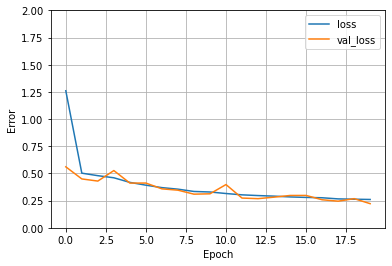

In [463]:
plot_loss(history)

In [456]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(250, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(5280, 7)
history1 = model.fit(x_train2, y_train2, validation_split=0.1,epochs=20, verbose=True)

Epoch 1/20
1620/1620 [==============================] - 15s 9ms/step - loss: 3.9052 - val_loss: 0.8087
Epoch 2/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.6004 - val_loss: 0.5099
Epoch 3/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.5166 - val_loss: 0.4220
Epoch 4/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.5039 - val_loss: 0.5746
Epoch 5/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.4379 - val_loss: 0.4221
Epoch 6/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.3928 - val_loss: 0.4031
Epoch 7/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.3540 - val_loss: 0.3074
Epoch 8/20
1620/1620 [==============================] - 14s 9ms/step - loss: 0.3306 - val_loss: 0.3132
Epoch 9/20
1620/1620 [==============================] - 15s 9ms/step - loss: 0.3207 - val_loss: 0.2765
Epoch 10/20
1620/1620 [==============================] - 14s 9ms/step - l

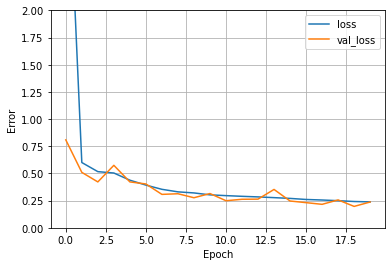

In [459]:
plot_loss(history1)

In [490]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(6680, 7)
history2 = model.fit(x_train, y_train, validation_split=0.1,epochs=40, callbacks=[callback], verbose=True)

Epoch 1/40
1620/1620 [==============================] - 17s 10ms/step - loss: 3.3274 - val_loss: 0.7776
Epoch 2/40
1620/1620 [==============================] - 17s 11ms/step - loss: 0.5631 - val_loss: 0.5886
Epoch 3/40
1620/1620 [==============================] - 17s 11ms/step - loss: 0.4859 - val_loss: 0.9182
Epoch 4/40
1620/1620 [==============================] - 18s 11ms/step - loss: 0.4947 - val_loss: 0.6447
Epoch 5/40
1620/1620 [==============================] - 18s 11ms/step - loss: 0.4259 - val_loss: 0.4946
Epoch 6/40
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3718 - val_loss: 0.4134
Epoch 7/40
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3487 - val_loss: 0.4872
Epoch 8/40
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3406 - val_loss: 0.3882
Epoch 9/40
1620/1620 [==============================] - 17s 11ms/step - loss: 0.3045 - val_loss: 0.3171
Epoch 10/40
1620/1620 [==============================] - 17s 11m

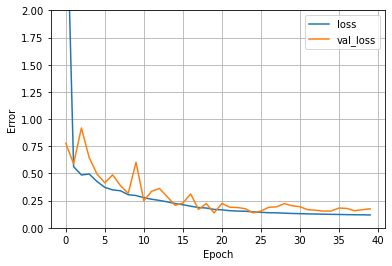

In [491]:
plot_loss(history2)

In [5]:
# Trying with DoG hist.
data1 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-doghist_0p5_4_by0p5-200bins.pkl')
data2 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-sshist_0p5_to_4_by0p5_660bins.pkl')
data3 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-doghist_0p5_4_by0p5-200bins-2.pkl')
data4 = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-2-sshist_0p5_to_4_by0p5_660bins-2.pkl')

x_train1, y_train1 = create_training_test_data(data1, 200, param_pos=0, data_pos=1, permute=False, n_leaveout=0)
x_train2, y_train2 = create_training_test_data(data2, 660, param_pos=0, data_pos=1, permute=False, n_leaveout=0)
x_train3, y_train3 = create_training_test_data(data3, 200, param_pos=0, data_pos=1, permute=False, n_leaveout=0)
x_train4, y_train4 = create_training_test_data(data4, 660, param_pos=0, data_pos=1, permute=False, n_leaveout=0)

In [6]:
x_train_m1, y_train_m1 =  merge_data(x_train1, x_train2, y_train1, y_train2)
x_train_m2, y_train_m2 =  merge_data(x_train3, x_train4, y_train3, y_train4)


In [7]:
x_train = np.vstack([x_train_m1, x_train_m2])
y_train = np.vstack([y_train_m1, y_train_m2])

In [9]:
fm.save_pickle((x_train, y_train), '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims1-6-57k-1and2-dogandhist-xytrain.pkl')

In [499]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(6680, 7)
history2 = model.fit(x_train, y_train, validation_split=0.1,epochs=40, callbacks=[callback], verbose=True)

Epoch 1/40
3240/3240 [==============================] - 37s 11ms/step - loss: 1.8679 - val_loss: 0.4684
Epoch 2/40
3240/3240 [==============================] - 36s 11ms/step - loss: 0.4956 - val_loss: 0.4362
Epoch 3/40
3240/3240 [==============================] - 36s 11ms/step - loss: 0.4196 - val_loss: 0.3669
Epoch 4/40
3240/3240 [==============================] - 35s 11ms/step - loss: 0.3410 - val_loss: 0.2373
Epoch 5/40
3240/3240 [==============================] - 35s 11ms/step - loss: 0.2980 - val_loss: 0.2792
Epoch 6/40
3240/3240 [==============================] - 36s 11ms/step - loss: 0.2673 - val_loss: 0.1348
Epoch 7/40
3240/3240 [==============================] - 35s 11ms/step - loss: 0.2470 - val_loss: 0.1437
Epoch 8/40
3240/3240 [==============================] - 35s 11ms/step - loss: 0.2285 - val_loss: 0.1171
Epoch 9/40
3240/3240 [==============================] - 38s 12ms/step - loss: 0.2176 - val_loss: 0.1720
Epoch 10/40
3240/3240 [==============================] - 35s 11m

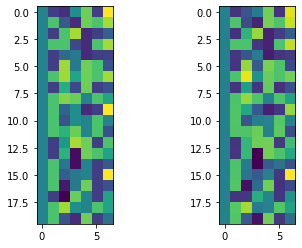

In [504]:
fig, ax = plt.subplots(1,2)
axes = np.ravel(ax)
p = np.random.permutation(x_train.shape[0])
axes[0].imshow(y_train[p[:20]])
axes[1].imshow(model.predict(x_train[p[:20]]))

## Pretty fuckin' good

This seems to lead to quite good prediction. I didn't really do this quite right with the testing, but I think it holds. Awesome.

How about differences?
    


In [33]:
x_train.shape

(115200, 6680)

In [13]:
x, y = make_data_similarity(x_train, y_train, 1000, 200)    

In [553]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0004,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(6680, 1)
history2 = model.fit(x, y, validation_split=0.1,epochs=10, callbacks=[callback], verbose=True)

Epoch 1/10
5625/5625 [==============================] - 62s 11ms/step - loss: 15.9637 - val_loss: 15.7389
Epoch 2/10
5625/5625 [==============================] - 55s 10ms/step - loss: 11.7893 - val_loss: 13.6207
Epoch 3/10
5625/5625 [==============================] - 56s 10ms/step - loss: 9.8193 - val_loss: 11.7504
Epoch 4/10
5625/5625 [==============================] - 55s 10ms/step - loss: 8.6324 - val_loss: 11.4194
Epoch 5/10
5625/5625 [==============================] - 61s 11ms/step - loss: 7.7797 - val_loss: 11.3985
Epoch 6/10
5625/5625 [==============================] - 55s 10ms/step - loss: 7.1388 - val_loss: 10.8688
Epoch 7/10
5625/5625 [==============================] - 55s 10ms/step - loss: 6.6316 - val_loss: 11.0855
Epoch 8/10
5625/5625 [==============================] - 58s 10ms/step - loss: 6.2245 - val_loss: 10.7838
Epoch 9/10
5625/5625 [==============================] - 54s 10ms/step - loss: 5.8741 - val_loss: 11.0278
Epoch 10/10
5625/5625 [==============================

In [36]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(6680, 1)
history2 = model.fit(x, y, validation_split=0.1,epochs=10, callbacks=[callback], verbose=True)

Epoch 1/10
5625/5625 [==============================] - 57s 10ms/step - loss: 15.7326 - val_loss: 17.1748
Epoch 2/10
5625/5625 [==============================] - 54s 10ms/step - loss: 11.6927 - val_loss: 15.6109
Epoch 3/10
5625/5625 [==============================] - 51s 9ms/step - loss: 9.8169 - val_loss: 14.1384
Epoch 4/10
5625/5625 [==============================] - 52s 9ms/step - loss: 8.6096 - val_loss: 13.9134
Epoch 5/10
5625/5625 [==============================] - 59s 10ms/step - loss: 7.7432 - val_loss: 14.0983
Epoch 6/10
5625/5625 [==============================] - 57s 10ms/step - loss: 7.1217 - val_loss: 13.3786
Epoch 7/10
5625/5625 [==============================] - 57s 10ms/step - loss: 6.6404 - val_loss: 14.0606
Epoch 8/10
5625/5625 [==============================] - 57s 10ms/step - loss: 6.2553 - val_loss: 13.2955
Epoch 9/10
5625/5625 [==============================] - 55s 10ms/step - loss: 5.9278 - val_loss: 13.2505
Epoch 10/10
5625/5625 [==============================] 

In [34]:
plot_loss(history2)

NameError: name 'history2' is not defined

In [17]:
x, y = make_data_similarity(x_train, y_train, 100, 200)    

In [57]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam'
)

def get_model(n_inputs, n_outputs):
    reg=1e-7
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(500, input_dim=n_inputs, kernel_initializer='he_uniform', activation='relu', activity_regularizer=tf.keras.regularizers.l2(reg)))
    model.add(tf.keras.layers.Dense(n_outputs))
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = get_model(6680, 1)
history3 = model.fit(x, y, validation_split=0.1,epochs=2, callbacks=[callback], verbose=True)

NameError: name 'x' is not defined

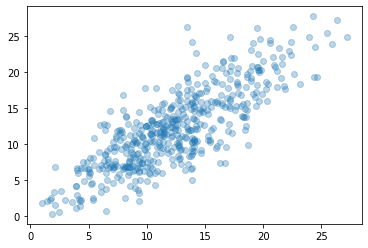

In [32]:
n = 500
plt.scatter(model.predict(x[:n]), y[:n], alpha=0.3)
#plt.hist(model.predict(x[:n]) - y[:n], bins=100);

(array([  2.,   0.,   0.,   1.,   0.,   0.,   3.,   1.,   0.,   0.,   1.,
          1.,   1.,   1.,   2.,   1.,   3.,   3.,   2.,   9.,   4.,   9.,
          8.,  12.,  14.,  15.,  20.,  26.,  18.,  35.,  32.,  33.,  52.,
         46.,  68.,  49.,  62.,  81.,  85., 102., 107., 146., 142., 172.,
        196., 220., 258., 283., 321., 355., 403., 441., 503., 526., 520.,
        558., 536., 473., 477., 388., 336., 265., 249., 218., 181., 128.,
        139., 108.,  82.,  70.,  70.,  56.,  45.,  35.,  31.,  32.,  19.,
         25.,  23.,  19.,  10.,   6.,  11.,   3.,   5.,   0.,   3.,   1.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([-19.80550173, -19.44256207, -19.0796224 , -18.71668274,
        -18.35374308, -17.99080342, -17.62786376, -17.2649241 ,
        -16.90198444, -16.53904478, -16.17610512, -15.81316546,
        -15.45022579, -15.08728613, -14.72434647, -14.36140681,
        -13.99846715, -13.63552749, -13.27258783, -12.90964817

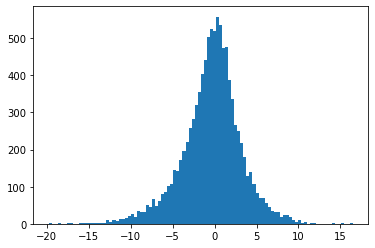

In [17]:
n = 10_000
#plt.scatter(model.predict(x[:n]), y[:n], alpha=0.3)
plt.hist(model.predict(x[:n]) - y[:n], bins=100);

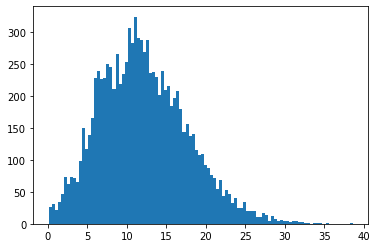

In [18]:
plt.hist(y[:10000], bins=100);

### Seems model is over-fitting pretty badly. Try bumping up regularization or adding dropout?

Learn for differences and parameters using 250k dataset.

In [34]:
def plot_loss(history):
  plt.plot(history['loss'], label='loss')
  plt.plot(history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

In [56]:


model = tf.keras.models.load_model('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-sampling-sshist-doghist-250k-predictparams-model/model')

SyntaxError: invalid syntax (2684275572.py, line 1)

In [40]:
x_test, y_test = fm.load_pickle("/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/simulations/sims-sampling-sshist-doghist-250k-300kdiffs_hist_test.pkl")

AttributeError: '_UserObject' object has no attribute 'predict'

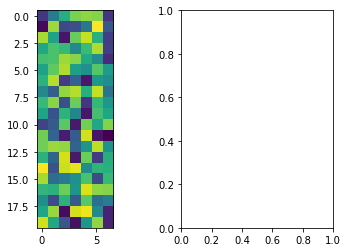

In [41]:
fig, ax = plt.subplots(1,2)
axes = np.ravel(ax)
axes[0].imshow(y_test2[:20])
axes[1].imshow(model.predict(x_test2)[:20])